# E4-Data Science Experiments and Testing Hypotheses
adaptation from Peter C. Bruce, Andrew Bruce, Peter Gedeck

In [ ]:
# import libraries
%matplotlib inline
import matplotlib.pylab as plt
import random

import pandas as pd
import numpy as np

from scipy import stats
from sklearn.utils import resample

import seaborn as sns


## Permutation A/B Test 
We compare two web pages based on time the users spend on them.

In [ ]:
# load the original data and transform it * 100
webdata = pd.read_csv("../data/web_page_data.csv")
webdata.Time = 100 * webdata.Time

In [ ]:
webdata.head()

In [ ]:
# use boxplot() function to calculate and plot the statistics for both subsets - Page A and Page B
ax = webdata.boxplot(by='Page', column='Time', figsize=(4, 4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

In [ ]:
# compare the mean statictics in both samples
meanA = webdata[webdata.Page == 'Page A'].Time.mean()
meanB = webdata[webdata.Page == 'Page B'].Time.mean()
print(meanA)
print(meanB)
print(meanB - meanA)
# is the difference statistically significant?

## Permutation Test for Significance
1. Combine all session times together
2. Repeatedly
- shuffle
- divide in groups

In [ ]:
# makes two new groups, return the difference between their means
def permutat(x, nA, nB):
    n = nA + nB
    newB = set(random.sample(range(n), nB))
    newA = set(range(n)) - newB
    return x.loc[newB].mean() - x.loc[newA].mean()


In [ ]:
# call the function, try sampling
nA = webdata[webdata.Page == 'Page A'].shape[0]
nB = webdata[webdata.Page == 'Page B'].shape[0]
print(permutat(webdata.Time, nA, nB))

In [ ]:
# call the function 1000 times to observe the distribution of the differences
random.seed(1)
perm_diffs = [permutat(webdata.Time, nA, nB) for i in range(1000)]

# use matplotlib for drawing
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = meanB - meanA, color='orange', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('web session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

The observed difference between samples is not signifficant, as it is in the range of chance variation.

In [13]:
print(np.mean([diff > meanB - meanA for diff in perm_diffs]))

0.121


***Can we reject H0?***

## t-Tests

In [14]:
# Estimate the similarity between the web pages above
res = stats.ttest_ind(webdata[webdata.Page == 'Page A'].Time, 
                      webdata[webdata.Page == 'Page B'].Time,
                      equal_var=False)

print(f'p-value for single sided test: {res.pvalue / 2:.4f}')


p-value for single sided test: 0.1408


In [15]:
import statsmodels.api as sm
tstat, pvalue, df = sm.stats.ttest_ind(
    webdata[webdata.Page == 'Page A'].Time, 
    webdata[webdata.Page == 'Page B'].Time,
    usevar='unequal', alternative='smaller')

print(f't-stat: {tstat:.4f}')
print(f'p-value: {pvalue:.4f}')

t-stat: -1.0983
p-value: 0.1408


## ANOVA

Used for testing hypotheses comparing multiple groups.

In [16]:
# load the file
four_sessions = pd.read_csv("../data/four_sessions.csv")

In [17]:
four_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


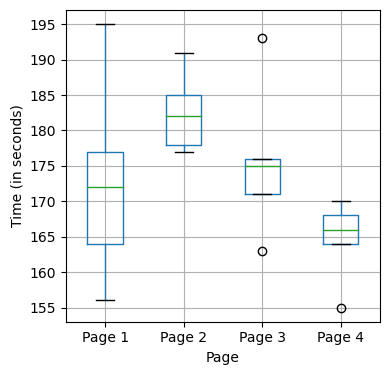

In [18]:
# plot it in boxplot

ax = four_sessions.boxplot(by='Page', column='Time', figsize=(4, 4))

ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

In [19]:
# compute permutation test with the web pages
observed_variance = four_sessions.groupby('Page').mean().var()[0]

print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

# Permutation test example
def perm_test(df):
    df = df.copy()
    df['Time'] = np.random.permutation(df['Time'].values)
    return df.groupby('Page').mean().var()[0]
    
print(perm_test(four_sessions))

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655
14.14666666666666


In [20]:
# compare variances 
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]

# print p-value
print('Prob', np.mean([var > observed_variance for var in perm_variance]))

Prob 0.07966666666666666


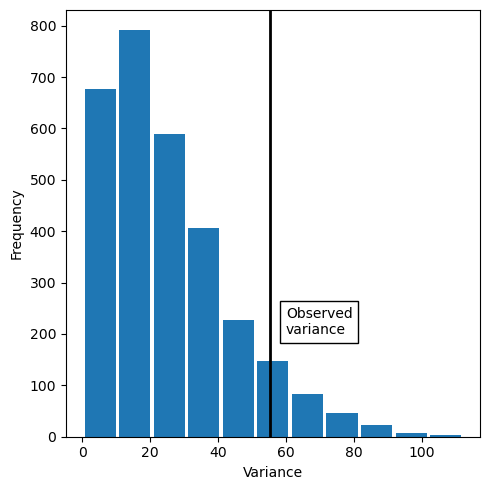

In [21]:
# plot the variances
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x = observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor':'white'})
ax.set_xlabel('Variance')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## F-Statistic
Compute F-value of ANOVA by means of statsmodels package.

Calculates the ratio of the variance accross group means (the treatment effect) to the variance due to residual error.<br>
Higher the ration, higher the significance of the result.

In [22]:
# use stistical packages
import statsmodels.api as sm
import statsmodels.formula.api as smf
# from statsmodels.stats import power
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN


## Chi-Square Test

Estimates the independency between samples

In [24]:
# load the test file with the observations
click_rate = pd.read_csv('../data/click_rates.csv')
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
clicks

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


In [25]:
# null hypothesis: all topics have same click rate - here are the expected values
row_average = clicks.mean(axis=1)
pd.DataFrame({
    'Headline A': row_average,
    'Headline B': row_average,
    'Headline C': row_average,
})

,Headline A,Headline B,Headline C
Click,,,
Click,11.333333,11.333333,11.333333
No-click,988.666667,988.666667,988.666667


In [26]:
# Calculate the residuals - the individual errors
def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

In [27]:
expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)
chi2observed

1.6659394708658917

In [28]:
# Resampling approach 
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)


In [30]:
xperm_chi2 = [perm_fun(box) for _ in range(2000)]
xperm_chi2

[2.1419221768275745,
 1.5171948752528646,
 0.2677402721034467,
 0.2974891912260517,
 1.1602078457816032,
 0.6544762206973154,
 1.6064416326206807,
 2.17167109595018,
 0.9817143310459718,
 1.6361905517432878,
 3.15338542699615,
 0.9222164928007606,
 6.782753559953985,
 0.05949783824521042,
 0.8032208163103405,
 1.1304589266589982,
 0.029748919122605393,
 0.5354805442068942,
 0.32723811034865674,
 0.505731625084288,
 1.4576970370076545,
 0.7734718971877355,
 2.1121732577049706,
 1.9931775812145482,
 0.6842251398199204,
 0.6544762206973144,
 0.3272381103486578,
 0.3272381103486578,
 1.3981991987624445,
 0.6544762206973154,
 5.4440521994367534,
 0.7734718971877355,
 1.8741819047241273,
 2.2311689341953915,
 1.695688389988497,
 0.6544762206973155,
 4.135099758042124,
 1.0114632501685779,
 0.2974891912260517,
 4.6110824640038075,
 2.8261473166474955,
 1.6064416326206816,
 0.4164848677164729,
 1.725437309111102,
 3.1533854269961514,
 2.350164610685812,
 1.4874459561302613,
 3.3021300226091768

In [31]:
resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'p-value: {pvalue:.4f}')

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'p-value: {pvalue:.4f}')

NameError: name 'perm_chi2' is not defined

## Chi-sq Distribution

Depends on the degrees of freedom.

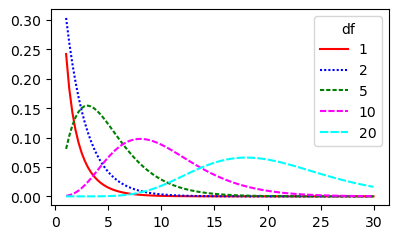

In [32]:
x = [1 + i * (30 - 1) / 99 for i in range(100)]

chi = pd.DataFrame({
    'x': x,
    'chi_1': stats.chi2.pdf(x, df=1),
    'chi_2': stats.chi2.pdf(x, df=2),
    'chi_5': stats.chi2.pdf(x, df=5),
    'chi_10': stats.chi2.pdf(x, df=10),
    'chi_20': stats.chi2.pdf(x, df=20),
})
fig, ax = plt.subplots(figsize=(4, 2.5))
ax.plot(chi.x, chi.chi_1, color='red', linestyle='-', label='1')
ax.plot(chi.x, chi.chi_2, color='blue', linestyle=(0, (1, 1)), label='2')
ax.plot(chi.x, chi.chi_5, color='green', linestyle=(0, (2, 1)), label='5')
ax.plot(chi.x, chi.chi_10, color='magenta', linestyle=(0, (3, 1)), label='10')
ax.plot(chi.x, chi.chi_20, color='cyan', linestyle=(0, (4, 1)), label='20')
ax.legend(title='df')

plt.tight_layout()
plt.show()